In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/semi_2

/content/drive/MyDrive/Colab Notebooks/semi_2


In [ ]:
# 패키지 임포트
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
import xgboost as xgb                                                                       # XGBoost
import lightgbm as lgb                                                                      # LightGBM
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from datetime import datetime

In [16]:
# 공용 클래스
class CustomUtils():
    @classmethod
    def pnow(_cls, op=''):
        """작업 내용과 현재 시간을 출력합니다."""
        from datetime import datetime

        msg_op = {'sm': 'Start MODELing', 'sp': 'Start PREDICTing', 'sf': 'Start FINISHing', 'es': 'End SAVing'}.get(op.lower(), 'Now')
        print(f'>> {msg_op} at', datetime.now().replace(microsecond=0))
    
    @classmethod
    def save_output(_cls, ids, pred, suffix=''):
        """제출용 파일을 생성합니다."""
        pd.DataFrame({'id': ids, 'pressure': pred}).to_csv(f'submission{suffix}.zip', index=False)

In [17]:
# 데이터 로드
dtypes = {'id': 'int32', 'breath_id': 'int32', 'R': 'int8', 'C': 'int8', 'u_out': 'int8'}
train_df = pd.read_csv('train.csv.zip', dtype=dtypes)
test_df = pd.read_csv('test.csv.zip', dtype=dtypes)
y_train = train_df['pressure']
train_ids = train_df['id']
test_ids = test_df['id']

# 파생변수 생성

관련 논문<sup>[(1)](#footnote_1a)</sup>, 피처 중요도, 케글 커뮤니티 등을 참고하여, 총 7개 항목의 64개 파생변수를 생성하여 활용하였습니다.

- [u_in] 통계량
- [u_in] 위치
- [u_in] 시간축 이동
- [u_in] 시간축 누적
- [u_in] 기타
- [R], [C]
- One-hot encoding


다음은 파생변수 생성에 참고한 피처 중요도의 예시입니다.

![lightgbm-feature-importance.png](https://jhs-public.s3.ap-northeast-2.amazonaws.com/semi_2/lightgbm-feature-importance.png)

![conv1d-feature-importance.png](https://jhs-public.s3.ap-northeast-2.amazonaws.com/semi_2/conv1d-feature-importance.png)

<sub><a name='footnote_1a'>(1)</a> Machine Learninig For Mechanical Ventilation Control, Daniel Suo, 2021.</sub>


In [18]:
# 파생변수 생성 (1시간 46분)
is_load_preprocessed = True

if is_load_preprocessed:
    dtypes = {'id': 'int32', 'breath_id': 'int32', 'R': 'int8', 'C': 'int8', 'u_out': 'int8'}
    all_df = pd.read_csv('all_prep.csv.zip', dtype=dtypes)
else:
    all_df = pd.concat([train_df, test_df], ignore_index=True)
    
    # [u_in] 통계량
    all_df['u_in_max'] = all_df.groupby('breath_id')['u_in'].transform('max')
    all_df['u_in_mean'] = all_df.groupby('breath_id')['u_in'].transform('mean')
    all_df['u_in_var'] = all_df.groupby('breath_id')['u_in'].transform('var')

    # [u_in] 위치
    all_df['u_in_pct'] = all_df['u_in'] / all_df['u_in_max']
    all_df['u_in_cumsum'] = all_df.groupby('breath_id')['u_in'].cumsum()
    all_df['u_in_cumsum_prev1'] = all_df.groupby('breath_id')['u_in_cumsum'].shift(1)
    all_df['u_in_squared'] = all_df['u_in'] ** 2
    all_df['u_in_sum'] = all_df.groupby('breath_id')['u_in'].transform('sum')
    all_df['u_in_diff_max'] = all_df.groupby(['breath_id'])['u_in'].transform('max') - all_df['u_in']
    all_df['u_in_diff_mean'] = all_df.groupby(['breath_id'])['u_in'].transform('mean') - all_df['u_in']
    u_in_nzero_df = all_df[all_df['u_in'] == 0][['breath_id', 'u_in']].groupby('breath_id').count().rename(columns={'u_in': 'u_in_nzero'}).reset_index()
    all_df = all_df.merge(u_in_nzero_df, how='left')  # u_in_nzero

    # [u_in] 시간축 이동
    for i in range(1, 5):
        colname = f'u_in_prev{i}'
        all_df[colname] = all_df.groupby('breath_id')['u_in'].shift(i).bfill()
        colname = f'u_in_next{i}'
        all_df[colname] = all_df.groupby('breath_id')['u_in'].shift(-i).ffill()
        colname = f'u_out_prev{i}'
        all_df[colname] = all_df.groupby('breath_id')['u_out'].shift(i).bfill()
        colname = f'u_out_next{i}'
        all_df[colname] = all_df.groupby('breath_id')['u_out'].shift(-i).ffill()
        colname = f'u_in_diff_prev{i}'
        all_df[colname] = (all_df['u_in'] - all_df[f'u_in_prev{i}'])
        colname = f'u_in_diff_next{i}'
        all_df[colname] = (all_df['u_in'] - all_df[f'u_in_next{i}'])

    # [u_in] 시간축 누적
    all_df['u_in_ma5'] = all_df.groupby('breath_id')['u_in'].rolling(5, min_periods=1).mean().reset_index(level=0, drop=True)
    all_df['u_in_ma10'] = all_df.groupby('breath_id')['u_in'].rolling(10, min_periods=1).mean().reset_index(level=0, drop=True)
    agg_fns = {'u_in_sum15': 'sum', 'u_in_mean15': 'mean', 'u_in_min15': 'min', 'u_in_max15': 'max'}
    all_df[list(agg_fns.keys())] = all_df.groupby('breath_id')['u_in'].rolling(15, min_periods=1).agg(agg_fns).reset_index(level=0, drop=True)

    # [u_in] 기타
    all_df['inex']= all_df['u_in'] * all_df['u_out']
    all_df['u_in_istip'] = (all_df['u_in'] - all_df['u_in_prev1']) * (all_df['u_in_next1'] - all_df['u_in']) < 0

    # [R], [C]
    all_df['R*C'] = all_df['R'] * all_df['C']
    all_df['R_C'] = all_df['R'].astype(str) + '_' + all_df['C'].astype(str)
    all_df['u_in_mean_by_RC'] = all_df.groupby(['R_C'])['u_in'].transform('mean')
    
    all_df.fillna({'u_in_cumsum_prev1': 0, 'u_in_pct': 0, 'u_in_nzero': 0}, inplace=True)

    # One-hot encoding
    all_df = pd.get_dummies(all_df, columns=['u_out', 'u_in_istip', 'R*C', 'R_C'])

    # 파일로 저장
    all_df.to_csv('all_prep.csv.zip', index=False)

    del u_in_nzero_df

In [19]:
# 데이터 확인
all_df

,id,breath_id,R,C,time_step,u_in,pressure,u_in_max,u_in_mean,u_in_var,u_in_pct,u_in_cumsum,u_in_cumsum_prev1,u_in_squared,u_in_sum,u_in_diff_max,u_in_diff_mean,u_in_nzero,u_in_prev1,u_in_next1,u_out_prev1,u_out_next1,u_in_diff_prev1,u_in_diff_next1,u_in_prev2,u_in_next2,u_out_prev2,u_out_next2,u_in_diff_prev2,u_in_diff_next2,u_in_prev3,u_in_next3,u_out_prev3,u_out_next3,u_in_diff_prev3,u_in_diff_next3,u_in_prev4,u_in_next4,u_out_prev4,u_out_next4,u_in_diff_prev4,u_in_diff_next4,u_in_ma5,u_in_ma10,u_in_sum15,u_in_mean15,u_in_min15,u_in_max15,inex,u_in_mean_by_RC,u_out_0,u_out_1,u_in_istip_False,u_in_istip_True,R*C_-112,R*C_-60,R*C_-56,R*C_-24,R*C_-12,R*C_-6,R*C_50,R*C_100,R_C_20_10,R_C_20_20,R_C_20_50,R_C_50_10,R_C_50_20,R_C_50_50,R_C_5_10,R_C_5_20,R_C_5_50
0,1,1,20,50,0.000000,0.083334,5.837492,28.313036,10.146007,102.488696,0.002943,0.083334,0.000000,0.006945,811.680524,28.229702,10.062673,15.0,0.083334,18.383041,0.0,0.0,0.000000,-18.299707,0.083334,22.509278,0.0,0.0,0.000000,-22.425944,0.083334,22.808822,0.0,0.0,0.000000,-22.725488,0.083334,25.355850,0.0,0.0,0.000000,-25.272516,0.083334,0.083334,0.083334,0.083334,0.083334,0.083334,0.000000,9.701022,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2,1,20,50,0.033652,18.383041,5.907794,28.313036,10.146007,102.488696,0.649278,18.466375,0.083334,337.936214,811.680524,9.929994,-8.237035,15.0,0.083334,22.509278,0.0,0.0,18.299707,-4.126236,0.083334,22.808822,0.0,0.0,18.299707,-4.425781,0.083334,25.355850,0.0,0.0,18.299707,-6.972809,0.083334,27.259866,0.0,0.0,18.299707,-8.876824,9.233188,9.233188,18.466375,9.233188,0.083334,18.383041,0.000000,9.701022,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,3,1,20,50,0.067514,22.509278,7.876254,28.313036,10.146007,102.488696,0.795015,40.975653,18.466375,506.667586,811.680524,5.803758,-12.363271,15.0,18.383041,22.808822,0.0,0.0,4.126236,-0.299544,0.083334,25.355850,0.0,0.0,22.425944,-2.846573,0.083334,27.259866,0.0,0.0,22.425944,-4.750588,0.083334,27.127486,0.0,0.0,22.425944,-4.618208,13.658551,13.658551,40.975653,13.658551,0.083334,22.509278,0.000000,9.701022,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,4,1,20,50,0.101542,22.808822,11.742872,28.313036,10.146007,102.488696,0.805594,63.784476,40.975653,520.242373,811.680524,5.504214,-12.662816,15.0,22.509278,25.355850,0.0,0.0,0.299544,-2.547028,18.383041,27.259866,0.0,0.0,4.425781,-4.451044,0.083334,27.127486,0.0,0.0,22.725488,-4.318663,0.083334,26.807732,0.0,0.0,22.725488,-3.998910,15.946119,15.946119,63.784476,15.946119,0.083334,22.808822,0.000000,9.701022,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,5,1,20,50,0.135756,25.355850,12.234987,28.313036,10.146007,102.488696,0.895554,89.140326,63.784476,642.919144,811.680524,2.957185,-15.209844,15.0,22.808822,27.259866,0.0,0.0,2.547028,-1.904016,22.509278,27.127486,0.0,0.0,2.846573,-1.771635,18.383041,26.807732,0.0,0.0,6.972809,-1.451881,0.083334,27.864715,0.0,0.0,25.272516,-2.508865,17.828065,17.828065,89.140326,17.828065,0.083334,25.355850,0.000000,9.701022,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10059995,4023996,125748,20,10,2.530117,4.971245,NaN,35.151391,2.682975,20.805408,0.141424,194.714841,189.743595,24.713281,214.638038,30.180146,-2.288270,34.0,4.965959,4.975709,1.0,1.0,0.005286,-0.004463,4.959653,4.979468,1.0,1.0,0.011593,-0.008222,4.952134,4.982648,1.0,1.0,0.019111,-0.011402,4.943394,4.985373,1.0,1.0,0.027852,-0.014127,4.958477,4.930841,73.183249,4.878883,4.693262,4.971245,4.971245,5.021857,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
10059996,4023997,125748,20,10,2.563853,4.975709,NaN,35.151391,2.682975,20.805408,0.141551,199.690549,194.714841,24.757678,214.638038,30.175682,-2.292733,34.0,4.971245,4.979468,1.0,1.0,0.004463,-0.003759,4.965959,4.982648,1.0,1.0,0.0097

In [20]:
# Scaling
is_load_scaled = True

if is_load_scaled:
    all_scaled = pd.read_csv('all_scaled.csv.zip').to_numpy()
else:
    scaler = RobustScaler()
    all_scaled = scaler.fit_transform(all_df)
    pd.DataFrame(all_scaled).to_csv('all_scaled.csv.zip', index=False)  # 메모리 부족 우회. 파일로 저장

# 데이터 나누기
X_train = all_scaled[:6_036_000, :]
X_test = all_scaled[6_036_000:, :]

del all_df, all_scaled

# 예측

2종류의 머신러닝 모델과 2종류의 딥러닝 모델을 활용하였습니다.
각각의 튜닝 결과와 kaggle 제출 점수는 다음과 같습니다.

- XGBoost
- LightGBM
- CNN-LSTM
- Bi-LSTM


## XGBoost

In [ ]:
# 파라미터 튜닝 및 모델링 (Regressor)
CustomUtils.pnow('sm')
kf = KFold(n_splits=7, shuffle=True, random_state=2021)
estimator = xgb.XGBRegressor(objective='reg:squarederror',
                             random_state=2021,
                             verbose=3,
                             tree_method='approx'
                             )
params = {'learning_rate': [0.1],'n_estimators': [100],'max_depth':[10]}
gs = GridSearchCV(estimator=estimator, param_grid=params, verbose=3, n_jobs=1, cv=kf)
gs.fit(X_train, y_train)

# 예측
CustomUtils.pnow('sp')
preds = gs.predict(X_test)

# pressure가 950 종류이므로, 가장 가까운 pressure로 치환
CustomUtils.pnow('sf')
y_train_unique = np.unique(y_train)
pred = [y_train_unique[np.abs(y_train_unique - p).argmin()] for p in pred]

# 출력 및 저장
print('* Best params : ', gs.best_params_, sep='\n')
print('* Score : ', gs.best_score_, sep='\t')
CustomUtils.save_output(test_ids, pred, suffix='_xgb')
CustomUtils.pnow('es')

>> Start MODELing at 2021-11-03 07:06:55
Fitting 7 folds for each of 1 candidates, totalling 7 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


![xgbr-modeling](https://jhs-public.s3.ap-northeast-2.amazonaws.com/semi_2/xgbr-modeling.png)

![xgbr-kaggle-score](https://jhs-public.s3.ap-northeast-2.amazonaws.com/semi_2/xgbr-kaggle-score.png)

먼저 XGBoost의 결과입니다. 모델링에서는 비록 시간이 걸리긴 했지만 score가 0.999로 나와서 많은 기대를 하였습니다. 하지만 kaggle 점수(MAE)로는 40이 넘는 좋지 않은 예측력을 보여주었습니다. 스코어링 방법이 다른 것으로 추측됩니다.

튜닝 과정에서 간과한 부분이 없는지 확인하는 것을 차후의 과제로 남겨둔 뒤, 다음 모델링으로 넘어갔습니다.


In [ ]:
# 모델링 및 예측

# 학습
CustomUtils.pnow()
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=2021, verbose=3, tree_method='approx', learning_rate=0.1, n_estimators=100, max_depth=10)
model.fit(X_train, y_train)

# 예측
CustomUtils.pnow('sp')
pred = model.predict(X_test)

# pressure가 950 종류이므로, 가장 가까운 pressure로 치환
CustomUtils.pnow('sf')
y_train_unique = np.unique(y_train)
pred = [y_train_unique[np.abs(y_train_unique - p).argmin()] for p in pred]

# 출력 및 저장
CustomUtils.save_output(test_ids, pred, suffix='_xgbr')
CustomUtils.pnow('es')

## LightGBM

다음으로 Gradient boosting을 개선한 LightGBM을 이용하였습니다.

In [ ]:
# 모델링 (Regressor)
CustomUtils.pnow('sm')
kf = KFold(n_splits=8, shuffle=True, random_state=2021)
params = {'learning_rate': [0.24], 'n_estimators': [12_000], 'num_leaves': [1200]}
gs = GridSearchCV(estimator=lgb.LGBMRegressor(), param_grid=params, verbose=3, n_jobs=1, cv=kf)
gs.fit(X_train, y_train)

# 예측
CustomUtils.pnow('sp')
pred = gs.predict(X_test)

# pressure가 950 종류이므로, 가장 가까운 pressure로 치환
CustomUtils.pnow('sf')
y_train_unique = np.unique(y_train)
pred = [y_train_unique[np.abs(y_train_unique - p).argmin()] for p in pred]

# 출력 및 저장
print('* Best params : ', gs.best_params_, sep='\n')
print('* Score : ', gs.best_score_, sep='\t')
CustomUtils.save_output(test_ids, pred, suffix='_lgbr')
CustomUtils.pnow('es')

![lightgbm-modeling](https://jhs-public.s3.ap-northeast-2.amazonaws.com/semi_2/lighrgbm-modeling.png)

![lightgbm-kaggle-score](https://jhs-public.s3.ap-northeast-2.amazonaws.com/semi_2/lightgbm-kaggle-score.png)

파생변수들을 추가 하고 튜닝 한 결과 score가 0.997로 향상되는 것을 볼 수 있습니다. LightGBM으로 예측한 결과의 kaggle 제출 점수는 0.5294 (MAE) 이었습니다.

 LightGBM의 성능에 영향을 주는 파라미터들은 learning_rate, n_estimators, num_leaves 등 이었는데, 일정 수준 (n_estimators = 4,000, num_leaves = 600) 부터는 score가 오르지 않아, 더 이상의 성능 개선은 어렵다고 판단하여 딥러닝을 활용해보도록 하였습니다.

# 딥러닝용 추가 코드

In [ ]:
# colab 가속기 선택
import tensorflow as tf
import os

accelerator = 'CPU' # 'CPU', 'GPU', 'TPU'

if accelerator == 'GPU':
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
elif accelerator == 'TPU':
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
# 1개 호흡 cycle마다 80개의 측정 frames. (batch_size, timesteps, features)
X_train = X_train.reshape(-1, 80, X_train.shape[-1])
X_test = X_test.reshape(-1, 80, X_test.shape[-1])
y_train = y_train.values.reshape(-1, 80)

X_train.shape, X_test.shape

## CNN-LSTM

![cnn_lstm-kaggle-score](https://jhs-public.s3.ap-northeast-2.amazonaws.com/semi_2/cnn_lstm-kaggle-score.png)
<br/><br/>

호흡 별 `u_in`의 변화에서 여러 패턴들로 수렴하는 특징이 발견되어, 각각의 호흡 단위를 하나의 이미지처럼 볼 수는 없을까? 라는 생각에서 LSTM 앞에 CNN 레이어를 추가하였습니다.

결과는 kaggle 제출 점수 0.2035 로 머신러닝보다 훨씬 더 우수한 성능을 보였습니다.

이 구조의 특징은 학습에 있었는데, ConvNet 또는 LSTM 만으로 구성된 것에 비해 loss가 선형으로 감소하는 모습을 보였습니다.<br/><br/>

![cnn_lstm-modeling](https://jhs-public.s3.ap-northeast-2.amazonaws.com/semi_2/cnn_lstm-modeling.png)


In [ ]:
# CNN-LSTM

CustomUtils.pnow('sm')

epoch = 500
batch_size = 384
n_folds = 10
learning_rate = 0.004
patience = 30
random_state = 2021

def get_model(filepath=None, **kwargs):
    if filepath:
        model = keras.models.load_model(filepath)
    else:
        input_dim = kwargs.get('input_dim', 1)
        learning_rate = kwargs.get('learning_rate', 0.001)
        n_class = kwargs.get('n_classes', 80)

        model = keras.models.Sequential([
            keras.layers.Input(shape=input_dim),
            keras.layers.Conv1D(filters=64, kernel_size=1, strides=1, padding='same', activation='selu'),
            keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
            keras.layers.Dense(64, activation='selu'),
            keras.layers.Dense(1)
        ])
        # Compile
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        # optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate, rho=0.8, decay=0.1)
        # optimizer = keras.optimizers.Adadelta(learning_rate=1.0, rho=0.98, epsilon=None, decay=0.002)
        # optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.3, nesterov=True)
        model.compile(optimizer=optimizer, loss='mae')

    return model
    
# with strategy.scope():  # TPU
with tf.device('/device:GPU:0'):  # GPU
# if True:  # CPU
    global epoch, batch_size, n_folds, learning_rate, patience, random_state

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    acc = []
    for fold_idx, [train_idx, valid_idx] in enumerate(kf.split(X_train)):
        X_train_splitted, X_valid_splitted = X_train[train_idx], X_train[valid_idx]
        y_train_splitted, y_valid_splitted = y_train[train_idx], y_train[valid_idx]

        # model = get_model('models/cnn_lstm_fold_1.hdf5')  # Loads model from file
        model = get_model(input_dim=X_train.shape[-2:], learning_rate=learning_rate)

        filepath = f'models/cnn_lstm_fold_{fold_idx}.hdf5'
        cp = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=0)
        es = EarlyStopping(monitor="val_loss", patience=patience, verbose=1, mode="min", restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=patience//3)
        hist = model.fit(X_train_splitted, y_train_splitted, validation_data=(X_valid_splitted, y_valid_splitted),
                         shuffle=True, epochs=epoch, batch_size=batch_size, callbacks=[cp, es, reduce_lr], verbose=2)

        best_score = min(hist.history['val_loss'])
        print('fold :', fold_idx, best_score, sep='\t')
        acc.append((fold_idx, best_score))


In [ ]:
# 예측 및 파일 생성

CustomUtils.pnow('sp')

# 모델 로드
filepath = 'models/cnn_lstm_fold_0.hdf5'
model = keras.models.load_model(filepath)

# 예측
pred = model.predict(X_test).squeeze().reshape(-1, 1).squeeze()

# pressure가 950 종류이므로, 가장 가까운 pressure로 치환
y_train_unique = np.unique(y_train)
pred = [y_train_unique[np.abs(y_train_unique - p).argmin()] for p in pred]

# 파일 출력
CustomUtils.save_output(test_ids, pred, suffix='_cnn_lstm')
CustomUtils.pnow('es')

## LSTM

![lstm-modeling](https://jhs-public.s3.ap-northeast-2.amazonaws.com/semi_2/lstm-modeling.png)
<br/><br/>
여러 겹의 양방향 LSTM으로 모델을 구성하였습니다.

kaggle score 에서 가장 좋은 결과를 보여주었습니다.

Importance가 낮은 feauture 몇 개를 수정 후, 다시 실행한 결과는 다음과 같습니다. 이 떄, 빠른 결과를 위해 folds는 3으로 주었습니다.

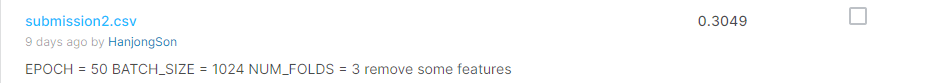

그 다음, num_folds를 10으로 지정한 뒤 결과는 다음과 같았습니다.

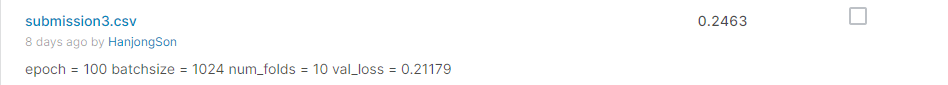

val_loss값을 모니터링한 결과, epoch의 크기가 너무 작다고 판단하였습니다. (Earlystopping이 일어나지 않았습니다.)
따라서, folds를 5로 줄인 뒤, epoch을 300으로 키웠습니다.

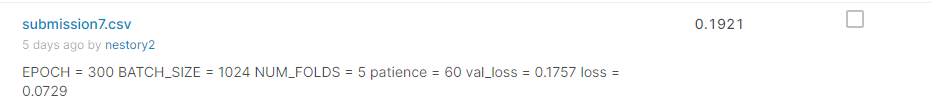

이 후 parameter가 아닌 feature을 새로 추가하고자 하였습니다. 그 결과는 다음과 같습니다.

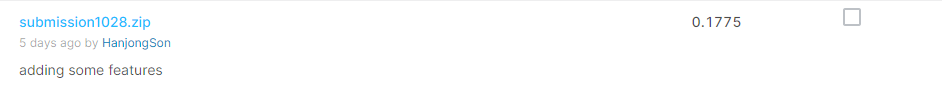

기존 모델에서 layer을 하나 더 추가한 결과입니다.

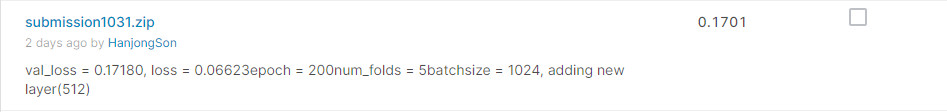

기존의 경우, kfold를 사용한 submission의 방법은 mean을 사용하였습니다. median으로 바꾼 후 결과의 모습입니다.

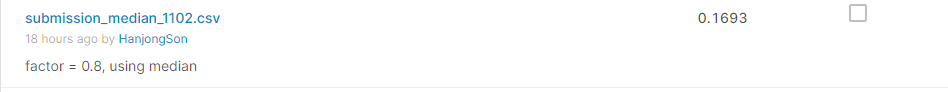







In [ ]:
# Bi-LSTM

CustomUtils.pnow('sm')

epoch = 700
batch_size = 384
n_folds = 10
learning_rate = 0.004
patience = 30
random_state = 2021

def get_model(filepath=None, **kwargs):
    if filepath:
        model = keras.models.load_model(filepath)
    else:
        input_dim = kwargs.get('input_dim', 1)
        learning_rate = kwargs.get('learning_rate', 0.001)
        model = keras.models.Sequential([
            keras.layers.Input(shape=input_dim),
            keras.layers.Bidirectional(keras.layers.LSTM(1024, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
            keras.layers.Dense(128, activation='selu'),
            keras.layers.Dense(1),
        ])
        # Compile
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        # optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate, rho=0.8, decay=0.01)
        # optimizer = keras.optimizers.Adadelta(learning_rate=1.0, rho=0.98, epsilon=None, decay=0.002)
        # optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.3, nesterov=True)
        model.compile(optimizer=optimizer, loss='mae')

    return model
    
with strategy.scope():  # TPU
# with tf.device('/device:GPU:0'):  # GPU
# if True:  # CPU
    global epoch, batch_size, n_folds, learning_rate, patience, random_state

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    acc = []
    for fold_idx, [train_idx, valid_idx] in enumerate(kf.split(X_train)):
        X_train_splitted, X_valid_splitted = X_train[train_idx], X_train[valid_idx]
        y_train_splitted, y_valid_splitted = y_train[train_idx], y_train[valid_idx]

        # model = get_model('models/lstm_fold_1.hdf5')    # Loads model from file
        model = get_model(input_dim=X_train.shape[-2:], learning_rate=learning_rate)

        filepath = f'models/lstm_fold_{fold_idx}.hdf5'
        cp = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=0)
        es = EarlyStopping(monitor="val_loss", patience=patience, verbose=1, mode="min", restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=patience//3)
        hist = model.fit(X_train_splitted, y_train_splitted, validation_data=(X_valid_splitted, y_valid_splitted),
                         shuffle=True, epochs=epoch, batch_size=batch_size, callbacks=[cp, es, reduce_lr], verbose=2)

        best_score = min(hist.history['val_loss'])
        print('fold :', fold_idx, best_score, sep='\t')
        acc.append((fold_idx, best_score))


In [ ]:
# 예측 및 제출용 파일 생성

preds = []
models = ['models/lstm_fold_0.hdf5',
          'models/lstm_fold_1.hdf5',
          'models/lstm_fold_2.hdf5',
          'models/lstm_fold_3.hdf5']

with strategy.scope():  # TPU
    for m in models:
        print('Loading model {}'.format(m))
        model = keras.models.load_model(m)

        preds.append(model.predict(X_test, batch_size=384, verbose=2).squeeze().reshape(-1, 1).squeeze())

submission = pd.read_csv('sample_submission.csv')

submission["pressure"] = np.median(np.vstack(preds), axis=0)
submission.to_csv('submission_median_1103.zip', index=False)

# 마치며

- 주제의 특성(medical)에 대한 배경지식 부족으로 인한 featuring의 어려움
- 파라미터 튜닝 미숙
- 시간 부족